# Nonconvex scalar Conservation Laws and the Osher Solution

This chapter presents the implementation of Osher's general solution to the scalar nonlinear Riemann problem that is valid also for non-convex fluxes, using the formula from <cite data-cite="osher1984"><a href="riemann.html#osher1984">(Osher 1984)</a></cite>:

$$
Q(\xi) = \begin{cases} 
    \text{argmin}_{q_l \leq q \leq q_r} [f(q) - \xi q]& \text{if} ~q_l\leq q_r,\\
    \text{argmax}_{q_r \leq q \leq q_l} [f(q) - \xi q]& \text{if} ~q_r\leq q_l.\\
\end{cases}
$$

See also Section 16.1 of <cite data-cite="fvmhp"><a href="riemann.html#fvmhp">(LeVeque 2002)</a></cite>.



*[Add some more general discussion of non-convex fluxes.]*

## Define a function returning the  Osher solution

We first define a function that can be used for any flux function $f(q)$ and left and right states. It returns the the single-valued Riemann solution consisting of shocks and rarefaction waves, and also returned the possibly multi-valued solution that would be obtained by tracing characteristics without regard to shock formation.

You can jump over the next few code cells if you just want to explore some examples of nonconvex problems.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import widgets, fixed
from ipywidgets import interact
from utils import riemann_tools
import numpy as np

The next cell defines a function that evaluates the Osher solution, and returns that function.

In [2]:
def osher_solution(f, q_left, q_right, n=1000):
    """
    Compute the Riemann solution to a scalar conservation law.
    
    Compute the similarity solution Q(x/t) and also the 
    (possibly multi-valued) solution determined by tracing 
    characteristics.
    
    Input:
      f = flux function (possibly nonconvex)
      q_left, q_right = Riemann data
      
    Returns:
      qtilde = function of xi = x/t giving the Riemann solution
    """

    from numpy import linspace,empty,argmin,argmax
    
    q_min = min(q_left, q_right)
    q_max = max(q_left, q_right)
    qv = linspace(q_min, q_max, n)
    
    # define the function qtilde as in (16.7)
    if q_left <= q_right:
        def qtilde(xi):
            Q = empty(xi.shape, dtype=float)
            for j,xij in enumerate(xi):
                i = argmin(f(qv) - xij*qv)
                Q[j] = qv[i]
            return Q
    else:
        def qtilde(xi):
            Q = empty(xi.shape, dtype=float)
            for j,xij in enumerate(xi):
                i = argmax(f(qv) - xij*qv)
                Q[j] = qv[i]
            return Q
    
    return qtilde

Using the function `osher_solution` we define a function `nonconvex_solutions` that evaluates this solution at a set of `xi = x/t` values.  It also computes the possibly multi-valued solution that would be obtained by tracing characteristics, for plotting purposes.  An additional function `make_plot_function` returns a plotting function for use in interactive widgets below.  

In [3]:
def nonconvex_solutions(f, q_left, q_right, xi_left=None, xi_right=None):
    """
    Compute the Riemann solution to a scalar conservation law.
    
    Compute the similarity solution Q(x/t) and also the 
    (possibly multi-valued) solution determined by tracing 
    characteristics.
    
    Input:
      f = flux function (possibly nonconvex)
      q_left, q_right = Riemann data
      xi_left, xi_right = optional left and right limits for xi = x/t
               in similarity solution.
               If not specified, chosen based on the characteristic speeds.
    
    Returns:
      xi = array of values between xi_left and xi_right
      q  = array of corresponding q(xi) values (xi = x/t)
      q_char = array of values of q between q_left and q_right
      xi_char = xi value for each q_char for use in plotting the
              (possibly multi-valued) solution where each q value
              propagates at speed f'(q).
    """
    
    from numpy import linspace,empty,argmin,argmax,diff,hstack
    
    qtilde = osher_solution(f, q_left, q_right)
    
    q_min = min(q_left, q_right)
    q_max = max(q_left, q_right)
    qv = linspace(q_min, q_max, 1000)
    
     
    xi = linspace(xi_left, xi_right, 1000)
    q = qtilde(xi)
    
    # The rest is just for plotting purposes:
    fv = f(qv)
    dfdq = diff(fv) / (qv[1] - qv[0])
    dfdq_min = dfdq.min()
    dfdq_max = dfdq.max()
    dfdq_range = dfdq_max - dfdq_min
    
    #print("Mininum characteristic velocity: %g" % dfdq_min)
    #print("Maximum characteristic velocity: %g" % dfdq_max)
    
    if xi_left is None: 
        xi_left = min(0,dfdq_min) - 0.1*dfdq_range
    if xi_right is None: 
        xi_right = max(0,dfdq_max) + 0.1*dfdq_range
        
    q_char = hstack((q_min, 0.5*(qv[:-1] + qv[1:]), q_max))
    
    if q_left <= q_right:
        xi_min = xi_left
        xi_max = xi_right
    else:
        xi_min = xi_right
        xi_max = xi_left
   
    xi_char = hstack((xi_min, dfdq, xi_max))
    
    return xi, q, q_char, xi_char
    

In [4]:
def plot_waves(f,q_left, q_right, xi_left, xi_right, n=1000, axes=None, t=0.2):
    qtilde = osher_solution(f, q_left, q_right, 3*n)
    xi = np.linspace(-2, 2, n)
    qvals = qtilde(xi)
    fvals = f(qvals)
    dxi = xi[1]-xi[0]
    smoothness = riemann_tools.detect_smoothness(qvals,dxi,dmax=10)
    values, ranges = riemann_tools.intervals(smoothness)
    wave_types, speeds = riemann_tools.make_waves(values, ranges, xi)
    riemann_tools.plot_waves(None,speeds,None,wave_types,ax=axes,t_pointer=False,t=t)

We also define a function that creates a `plot_function` useful in creating plots of the solutions below.

In [5]:
def make_plot_function(f, q_left, q_right, xi_left, xi_right):
    
    xi, qxi, q_char, xi_char = nonconvex_solutions(f, q_left, q_right, 
                                              xi_left, xi_right)
    def plot_function(t=0.2, fig=0):
        """
        Create plot at time t.
        Nonzero fig is used only by jsanimate_widgets when
        converting to html files.
        """
        if fig==0: 
            plt.figure(figsize=(14,6))
            
        # plot solution q(x,t):
        plt.subplot(1,3,1)
        # from characteristic-based solution:
        plt.plot(xi_char*t,q_char,'k--') 

        # single-valued solution, extended full domain:
        xi_plot = np.hstack((xi_left,xi*t,xi_right))
        q_plot = np.hstack((q_left,qxi,q_right))
        plt.plot(xi_plot, q_plot, 'k', linewidth=2)
        plt.title('Solution q(x,t) at t = %4.2f' % t)
        plt.xlabel('x')

        plt.xlim(xi_left,xi_right)
        
        # plot flux function and convex hull:
        plt.subplot(1,3,3)
        q_plot = np.linspace(q_left, q_right, 1000)
        f_plot = f(q_plot)
        plt.plot(q_plot, f_plot, 'k--', label='f(q)')
        plt.plot(qxi, f(qxi),'k', label='Convex hull')
        plt.plot([q_left,q_right],[f(q_left),f(q_right)],'bo')
        plt.title('Flux function')
        plt.xlabel('q')
        plt.legend()

        ax = plt.subplot(1,3,2)
        plot_waves(f,q_left,q_right,xi_left,xi_right,n=1000,axes=ax,t=t)
        ax.set_xlim(xi_left,xi_right)
        
        if fig==0: plt.show()
        return None
    return plot_function

## Traffic flow

First try a convex flux, such as $f(q) = q(1-q)$ from traffic flow (with $q$ now representing the density $\rho$ that was used in [Traffic_flow.ipynb](Traffic_flow.ipynb)).

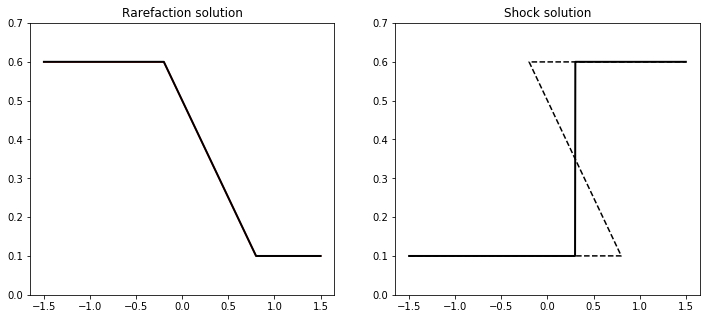

In [6]:
f = lambda q: q*(1-q)

plt.figure(figsize=(12,5))
plt.subplot(121)

q_left = 0.6;  q_right = 0.1
xi, qxi, q_char, xi_char = nonconvex_solutions(f, q_left, q_right, -1.5,1.5)
plt.plot(xi_char, q_char,'r')
plt.plot(xi, qxi, 'k', linewidth=2)
plt.ylim(0.,0.7)
plt.title('Rarefaction solution')

plt.subplot(122)

q_left = 0.1;  q_right = 0.6
xi, qxi, q_char, xi_char = nonconvex_solutions(f, q_left, q_right, -1.5,1.5)
plt.plot(xi_char, q_char,'k--')
plt.plot(xi, qxi, 'k', linewidth=2)
plt.ylim(0.,0.7)
plt.title('Shock solution');

The plot on the left above shows a case where the solution is a rarefaction wave that can be computed by tracing characteristics.  On the right we see the case for which tracing characteristics would give an multivalued solution (as a dashed line) whereas the correct Riemann solution consists of a shock wave (solid line).

## Buckley-Leverett Equation

The Buckley-Leverett equation for two-phase flow is described in Section 16.1.1 of <cite data-cite="fvmhp"><a href="riemann.html#fvmhp">(LeVeque 2002)</a></cite>.  It has the non-convex flux function

$$ 
f(q) = \frac{q^2}{q^2 + a(1-q)^2}
$$
where $a$ is some constant, $q=1$ corresponds to pure water and $q=0$ to pure oil, in a saturated porous medium. 

Consider the Riemann problem for water intruding into oil, with $q_l=1$ and $q_r=0$.

In [7]:
a = 0.5
f_buckley_leverett = lambda q: q**2 / (q**2 + a*(1-q)**2)

q_left = 1.
q_right = 0.

### Plot the flux and its derivative

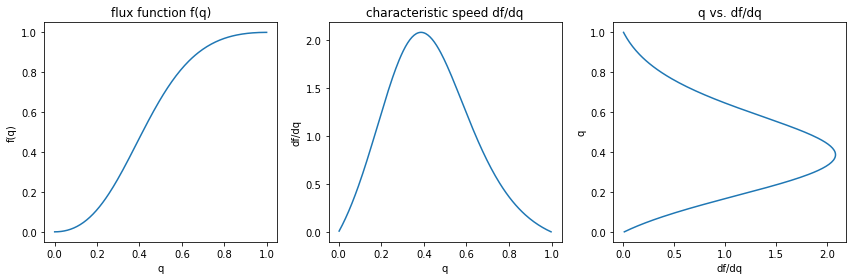

In [8]:
qvals = np.linspace(q_right, q_left, 200)
fvals = f_buckley_leverett(qvals)
dfdq = np.diff(fvals) / (qvals[1]-qvals[0])  # approximate df/dq
qmid = 0.5*(qvals[:-1] + qvals[1:])   # midpoints for plotting dfdq

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(qvals,fvals)
plt.xlabel('q')
plt.ylabel('f(q)')
plt.title('flux function f(q)')

plt.subplot(132)
plt.plot(qmid, dfdq)
plt.xlabel('q')
plt.ylabel('df/dq')
plt.title('characteristic speed df/dq')

plt.subplot(133)
plt.plot(dfdq, qmid)
plt.xlabel('df/dq')
plt.ylabel('q')
plt.title('q vs. df/dq')

plt.subplots_adjust(left=0.)
plt.tight_layout()

Note that the third plot above shows $q$ on the vertical axis and $df/dq$ on the horizontal axis (it's the middle figure turned sideways).  You can think of this as showing the characteristic velocity for each point on a jump discontinuity from $q=0$ to $q=1$, and hence a triple valued solution of the Riemann problem at $t=1$ when each $q$ value has propagated this far.  

Below we show this together with the correct solution to the Riemann problem, with a shock wave inserted (as computed using the Osher solution defined above).  Note that for this non-convex flux function the Riemann solution consists partly of a rarefaction wave together with a shock wave.

In the plot on the right, we also show the flux function $f(q)$ as a red curve and the upper boundary of the convex hull of the set of points below the graph for $q_r \leq q \leq q_l$.  Note that the convex hull boundary follows the flux function for the set of $q$ values corresponding to the rarefaction wave and then jumps from $q\approx 0.6$ to $q=0$, corresponding to the shock wave.  See Section 16.1 of <cite data-cite="fvmhp"><a href="riemann.html#fvmhp">(LeVeque 2002)</a></cite> for more discussion of this construction of the Riemann solution.

In [9]:
q_left = 1.
q_right = 0.
plot_function = make_plot_function(f_buckley_leverett, 
                 q_left, q_right, xi_left=-2, xi_right=2)

interact(plot_function, 
         t=widgets.FloatSlider(value=0,min=0,max=.9),
         fig=fixed(0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

### RJL comment:

dashed line at t in x-t plot above (and others below) doesn't extend far enough left or right

=========

## Sinusoidal flux

As another test, the flux function $f(q) = \sin(q)$ is used in Example 16.1 of <cite data-cite="fvmhp"><a href="riemann.html#fvmhp">(LeVeque 2002)</a></cite> to produce the Figure 16.4 in that book.

In [10]:
f_sin = lambda q: np.sin(q)

q_left = np.pi/4.
q_right = 15*np.pi/4.

plot_function = make_plot_function(f_sin, q_left, q_right, -1.5, 1.5)

interact(plot_function, 
         t=widgets.FloatSlider(value=0.,min=0.,max=.9),
         fig=fixed(0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

In the figure above, note that the shocks in the Riemann solution correspond to linear segments of the lower boundary of the convex hull of the set of points that lie above the flux function $f(q)$.  This is because we chose $q_l < q_r$ in this example.

If we switch the states so that $q_l > q_r$, then as in the Buckley-Leverett example above, the Riemann solution corresponds to the upper boundary of the convex hull of the set of points that lie below the flux function:

In [11]:
f_sin = lambda q: np.sin(q)

q_left = 15*np.pi/4.
q_right = np.pi/4.

plot_function = make_plot_function(f_sin, q_left, q_right, -1.5, 1.5)

interact(plot_function, 
         t=widgets.FloatSlider(value=0.,min=0.,max=.9),
         fig=fixed(0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

## Yet another example

Here's another example where the flux function $f(q) = q\sin(q)$ is even more oscillatory over the region $q_l \leq q \leq q_r$.  Note the collection of shock and rarefaction waves that result from this.

In [15]:
f = lambda q: q*np.sin(q)
q_left = 2.
q_right = 22.

plot_function = make_plot_function(f, q_left, q_right, -25,20)

interact(plot_function, 
         t=widgets.FloatSlider(value=0.,min=0.,max=.9),
         fig=fixed(0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

### RJL comment:

In plot above, waves in x-t plane all compressed in center.  Looks somewhat better if limits in `make_plot_function` are `-10,10` rather than `-25,20`, but too many characteristics are plotted.

In plot below, characteristic fans have big gaps, not clear why?

==========

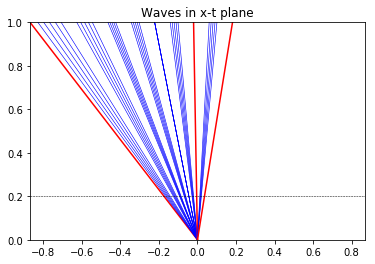

In [16]:
plot_waves(f_sin,q_left,q_right,-5,5,n=100)

What does the Riemann solution look like if you switch the left and right states in this example?

Experiment with other flux functions in this notebook!